### Example notebook to demonstrate dimensionality reduction and clustering of coherence matrices

In [27]:
# Import modules
import numpy as np
from sklearn.decomposition import PCA
import glob
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

In [24]:
# Defining some functions for clustering dendrograms and reconstruction of covariance matrices

def plot_dendrogram(model, **kwargs):
    """Create linkage matrix and then plot the dendrogram"""
    
    # Create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


def reconstruct_matrix(X, ind, inv_scale=True):
    """Reconstruct matrix from one dimensional (full) feature vector"""
    first_covmat_recov = np.eye(first_covmat.shape[0])
    if inv_scale:
        X_ind = scaler.inverse_transform(X[ind])
        first_covmat_recov[np.triu_indices(first_covmat.shape[0], k = 1)] = X_ind
        first_covmat_recov.T[np.triu_indices(first_covmat.shape[0], k = 1)] = X_ind
    else:
        first_covmat_recov[np.triu_indices(first_covmat.shape[0], k = 1)] = X[ind,:]
        first_covmat_recov.T[np.triu_indices(first_covmat.shape[0], k = 1)] = X[ind,:]
    return first_covmat_recov

def reconstruct_matrix_pca(X_pca, ind, pca, ncomp_r=None, inv_scale=True):
    """Reconstruct matrix from reduced feature vector"""
    first_features_recov = X_pca[ind,:ncomp_r] @ pca.components_[:ncomp_r,:]
    if inv_scale:
        first_features_recov = scaler.inverse_transform(first_features_recov)
    first_covmat_recov = np.eye(first_covmat.shape[0])
    first_covmat_recov[np.triu_indices(first_covmat.shape[0], k = 1)] = first_features_recov
    first_covmat_recov.T[np.triu_indices(first_covmat.shape[0], k = 1)] = first_features_recov
    return first_covmat_recov


def reconstruct_centroid(X_centroid, pca, ncomp_r=None, inv_scale=False):
    first_features_recov = X_centroid[:ncomp_r] @ pca.components_[:ncomp_r,:]
    if inv_scale:
        first_features_recov = scaler.inverse_transform(first_features_recov)
    first_covmat_recov = np.eye(first_covmat.shape[0])
    first_covmat_recov[np.triu_indices(first_covmat.shape[0], k = 1)] = first_features_recov
    first_covmat_recov.T[np.triu_indices(first_covmat.shape[0], k = 1)] = first_features_recov
    return first_covmat_recov

In [3]:
directory = "out/covmats_band/"
files_all = sorted(glob.glob(directory + '*.npy'))
len(files_all)

744

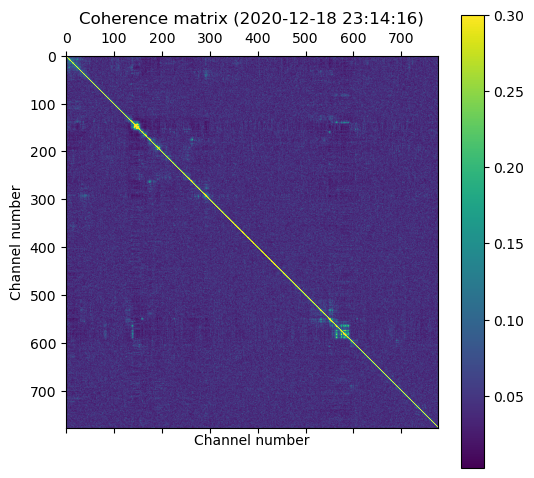

In [35]:
# Load random covariance matrix and take the median over a specified frequencies band
fig, ax = plt.subplots(figsize=(6,6), dpi=100)
sCh, eCh = 0, -1
ind = 180
fb = 2
first_covmat = np.median(np.load(files_all[ind])[fb*10:(fb+1)*10,sCh:eCh,sCh:eCh],axis=0)

# Extract date and time information from filename
date, time, window_id_long = files_all[ind].split('/')[-1].split('_')
year, month, day = date.split('-')
hour, minute, second = time.split('-')
window_id = window_id_long.split('=')[-1].split('.')[0]
extra_time = datetime.timedelta(minutes=int(window_id)*20)
time_str = f'{day}/{month}/{year} {hour}:{minute}:{second}'
date_format_str = '%d/%m/%Y %H:%M:%S'
given_time = datetime.datetime.strptime(time_str, date_format_str)

# Plot covariance matrix
im = ax.matshow(first_covmat[:,:],vmax=0.3, interpolation=None)
cbar = plt.colorbar(im)
plt.xlabel("Channel number")
plt.ylabel("Channel number")
plt.title(f"Coherence matrix ({given_time + extra_time})")
plt.show()

In [5]:
# Only use elements above diagonal, since matrix is symmetric
first_uptri = np.triu(first_covmat)
first_features = first_uptri[np.triu_indices(first_covmat.shape[0], k = 1)].reshape(-1,1)
first_features.shape

(301476, 1)

In [7]:
from tqdm import tqdm

nMatrices = len(files_native)
nFeatures = (first_covmat.shape[0] * first_covmat.shape[1] - first_covmat.shape[0]) // 2
X0 = np.zeros((nMatrices, nFeatures))
X1 = np.zeros((nMatrices, nFeatures))
X2 = np.zeros((nMatrices, nFeatures))

for k in tqdm(range(nMatrices)):
    full_covmat = np.load(files_native[k])[:,:]
    test_covmat0 = np.median(full_covmat[:20,:,:],axis=0)
    test_covmat1 = np.median(full_covmat[20:40,:,:],axis=0)
    test_covmat2 = np.median(full_covmat[40:,:,:],axis=0)

    test_uptri0 = np.triu(test_covmat0)
    test_uptri1 = np.triu(test_covmat1)
    test_uptri2 = np.triu(test_covmat2)
    
    test_features0 = test_uptri0[np.triu_indices(first_covmat.shape[0], k = 1)]
    test_features1 = test_uptri1[np.triu_indices(first_covmat.shape[0], k = 1)]
    test_features2 = test_uptri2[np.triu_indices(first_covmat.shape[0], k = 1)]
    
    X0[k,:] = test_features0
    X1[k,:] = test_features1
    X2[k,:] = test_features2

100%|██████████| 744/744 [37:40<00:00,  3.04s/it]


In [6]:
# Run PCA on the whole dataset and reduce to 100 eigenvectors / eigenvalues
# Clustering will be performed on the eigenvalues, while the eigenvectors give an idea of the characteristics
# of the data
n_comp = 100  # Reduce to 100 dimensions
pca = PCA(n_components=n_comp)
pca.fit(X1)
X_pca = pca.transform(X1)
X_pca.shape

(744, 100)

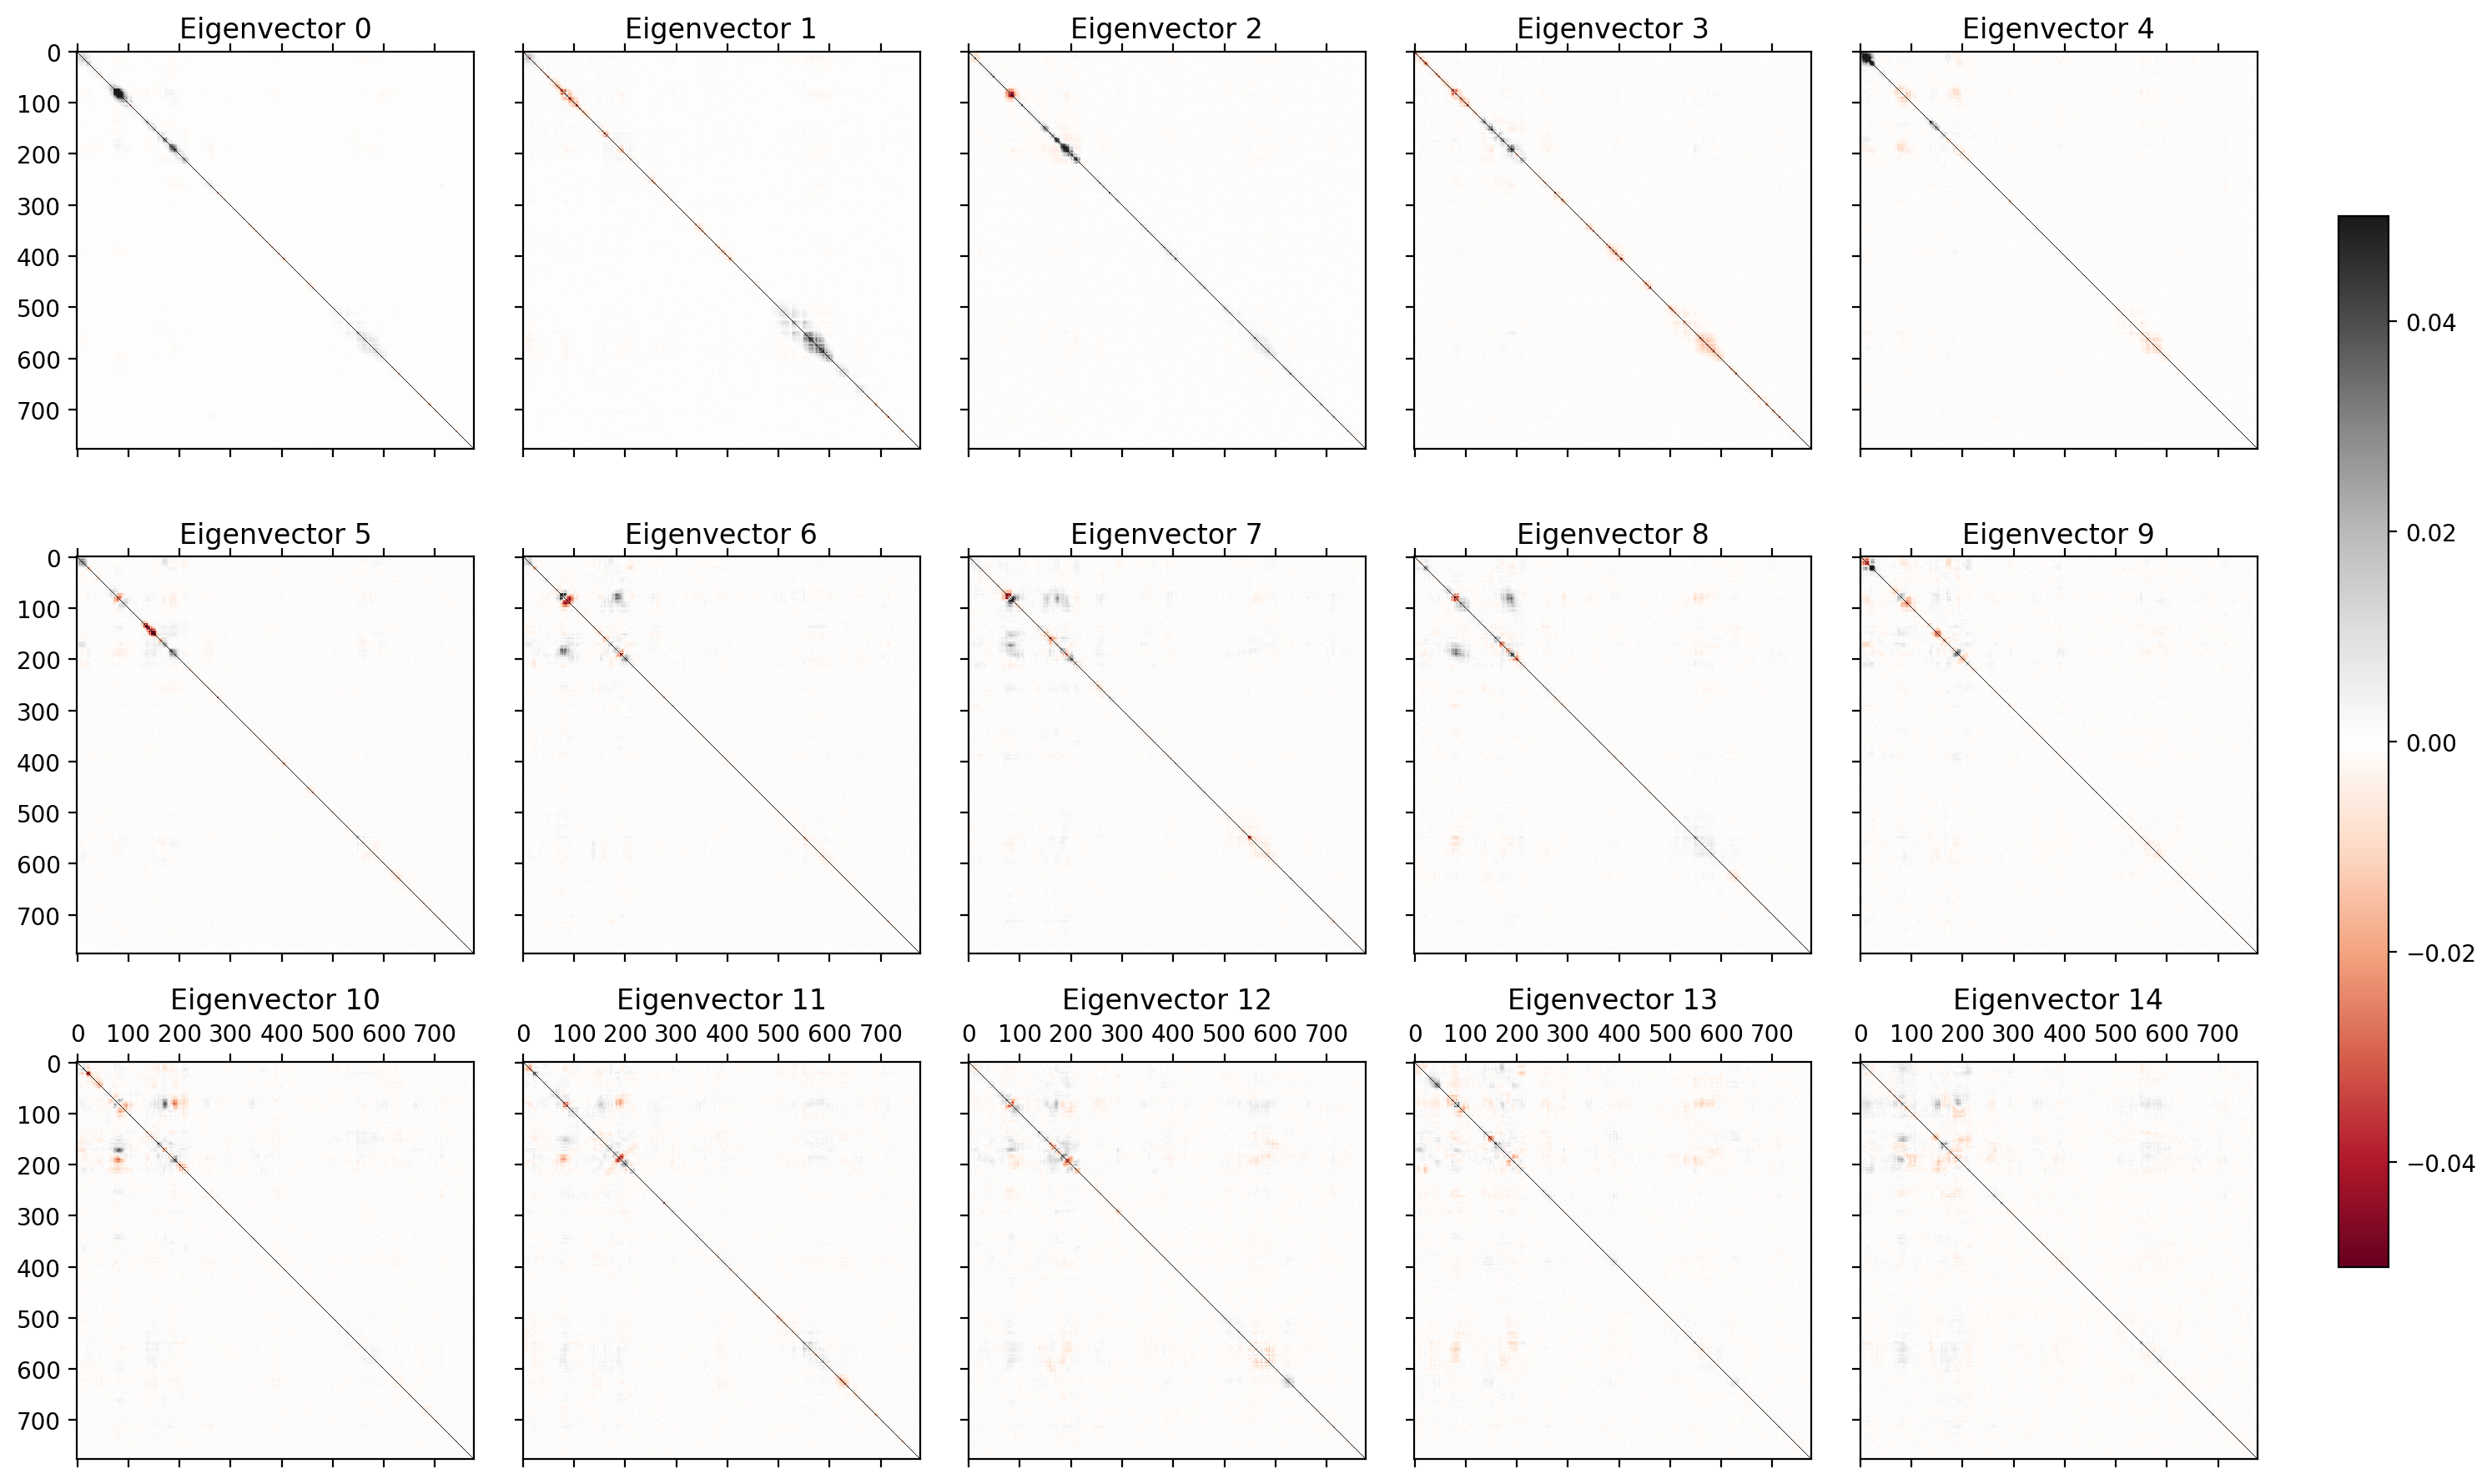

In [36]:
# Plotting the first 15 eigenvectors
# Eigenvector 0 emphasizes a noise source around channel 100. Eigevector 1 emphasizes a noise source around
# channel 600. Eigenvector 2 shows a noise source around channel number 200 and Eigenvector 4 has high
# contribution at the very first channels. In this example, higher Eigenvectors don't describe individual sources
# but give more detail to fully describe the original coherence matrices.
vmax_eig = 0.05
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(15, 9),
                        sharex=True, sharey=True, dpi=200)
for ax_id, ax in enumerate(axs.reshape(-1)):
    first_eigvec = reconstruct_matrix(pca.components_, ind=ax_id, inv_scale=False)
    im2 = ax.matshow((first_eigvec)[:,:], vmax=vmax_eig, vmin=-vmax_eig, cmap='RdGy')
    ax.set_title(f"Eigenvector {ax_id}")
    plt.tight_layout()
    
fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.94, 0.15, 0.02, 0.7])
fig.colorbar(im2, cax=cbar_ax)
plt.show()

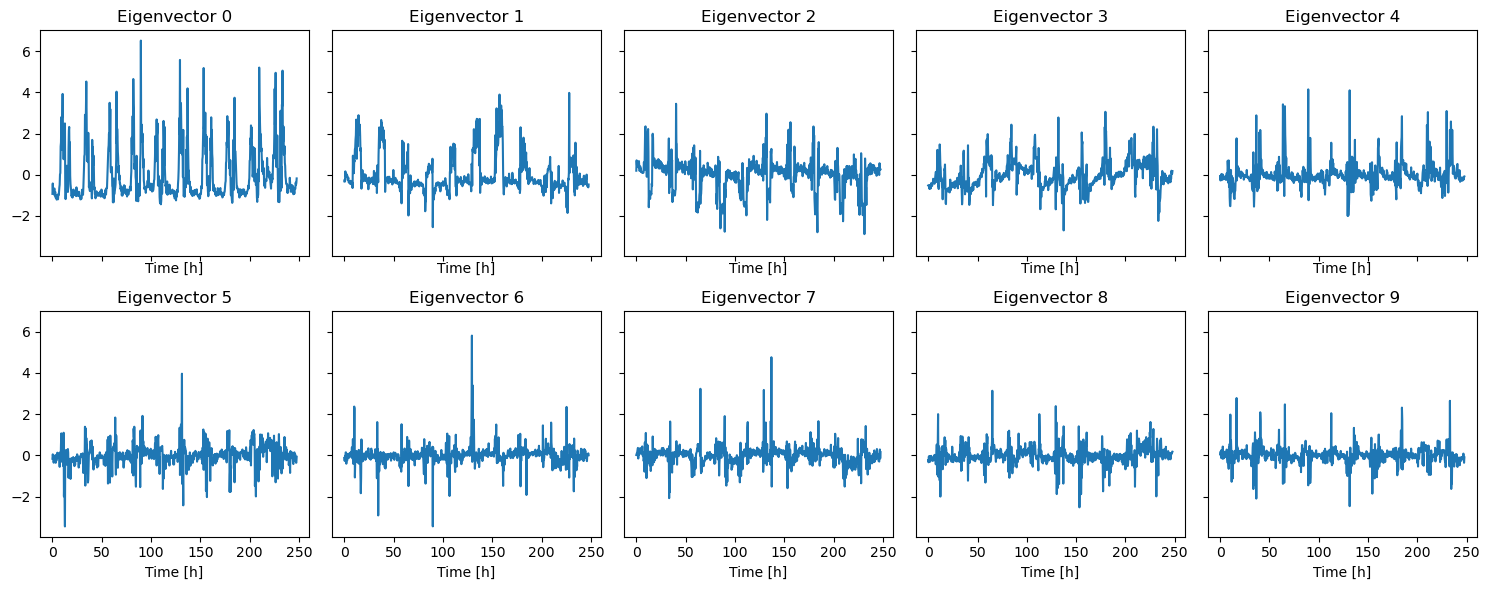

In [37]:
# Time series of the individual eigenvectors. We can clearly see a diurnal pattern.

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15, 6),
                        sharex=True, sharey=True, dpi=100)

time_axis = np.arange(0,(X_pca).shape[0]//3,1/3)
for ax_id, ax in enumerate(axs.reshape(-1)):
    ax.plot(time_axis, X_pca[:,ax_id])
    ax.set_title(f"Eigenvector {ax_id}")
    ax.set_xlabel("Time [h]")
    plt.tight_layout()

Text(0, 0.5, 'Eigenvalue')

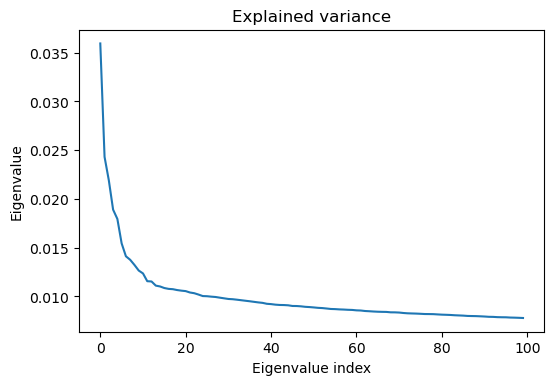

In [10]:
# Eigenvalue distribution
plt.figure(dpi=100)
plt.plot(pca.singular_values_ / sum(pca.singular_values_))
plt.title("Explained variance")
plt.xlabel('Eigenvalue index')
plt.ylabel('Eigenvalue')

In [20]:
# Reconstructing a covariance matrix with only 10 components
# Most imporant characteristics of the covariance matrix are recovered while noise far away from the diagonal
# is reduced
ind = 388
ncomp_r = 10
first_covmat_recov_pca = reconstruct_matrix_pca(X_pca, ind, pca, ncomp_r=ncomp_r,inv_scale=False)
first_covmat_recov = reconstruct_matrix(X1, ind, inv_scale=False)

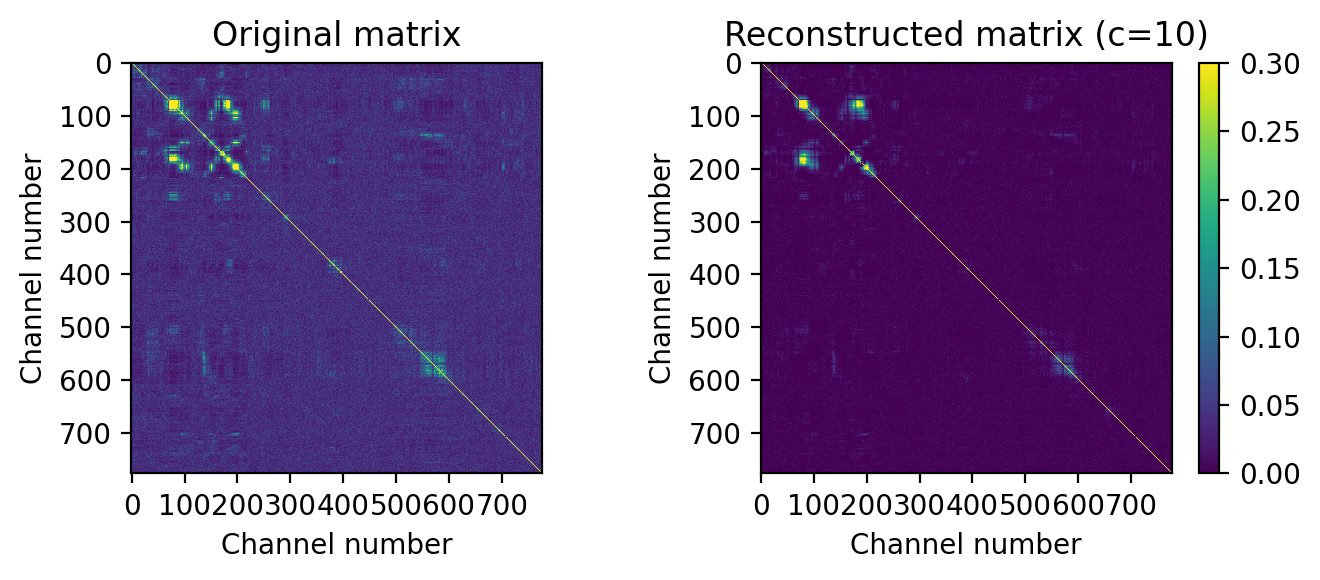

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(7,3), dpi=200)
axes[0].matshow(first_covmat_recov[:,:], vmax=0.3, vmin=0)
axes[0].xaxis.set_ticks_position('bottom')
axes[0].set_title("Original matrix")
axes[0].set_xlabel('Channel number')
axes[0].set_ylabel('Channel number')
im = axes[1].matshow(first_covmat_recov_pca[:,:], vmax=0.3, vmin=0)
cbar = plt.colorbar(im)
axes[1].xaxis.set_ticks_position('bottom')
axes[1].set_title(f"Reconstructed matrix (c={ncomp_r})")
axes[1].set_xlabel('Channel number')
axes[1].set_ylabel('Channel number')
plt.tight_layout()

plt.show()

In [25]:
# Scale Eigenvectors to same maximum amplitude
scaler = MinMaxScaler()
X_pca_s = scaler.fit_transform(X_pca)

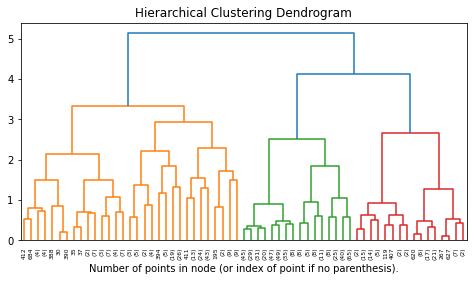

In [26]:
# Plot a dendrogram for agglomerative clustering of first 10 PCA components

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X_pca_s[:,:10])
fig = plt.figure(figsize=(8,4))
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode="level", p=5)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [28]:
model_real = AgglomerativeClustering(n_clusters=6)

model_real = model_real.fit(X_pca_s[:,:10])
print(f"Silhouette score:{silhouette_score(X=X_pca_s[:,:10], labels=model_real.labels_)}")

Silhouette score:0.34601102075371476


In [29]:
for k in range(6):
    nelem = np.where(model_real.labels_ == k)[0].shape[0]
    print(f"Cluster {k} has {nelem} members")

Cluster 0 has 434 members
Cluster 1 has 102 members
Cluster 2 has 56 members
Cluster 3 has 45 members
Cluster 4 has 65 members
Cluster 5 has 42 members


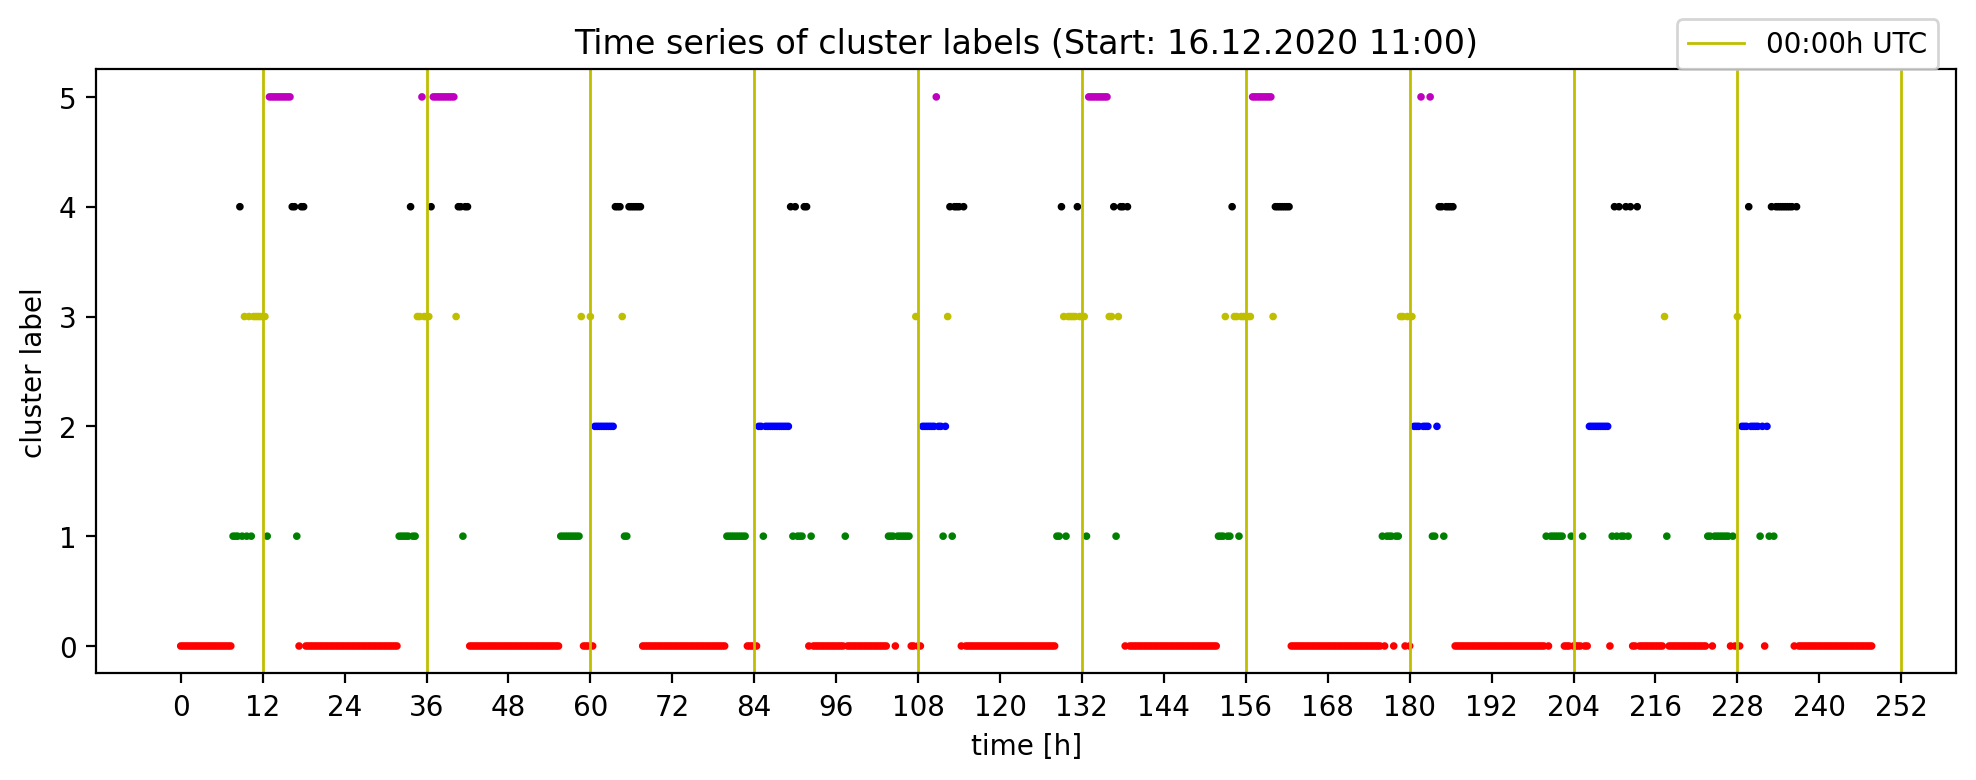

In [38]:
# Cluster labels vs time plot. This shows a clear effect of day versus night noise patterns

colormap = np.array(['r', 'g', 'b', 'y', 'k', 'm'])

fig3 = plt.figure(figsize=(12,4), dpi=200)
plt.scatter(np.arange(0,(model_real.labels_).shape[0]//3,1/3), model_real.labels_,
            s=3, c=colormap[model_real.labels_])
intv = 12
plt.xticks(np.arange(0, (model_real.labels_).shape[0]//3+intv, intv))
vlcoords = np.arange(0,(model_real.labels_).shape[0]//3,24) + 12
for i, xc in enumerate(vlcoords):
    plt.axvline(x=xc, c='y', lw=1, label='00:00h UTC' if i == 0 else "")
plt.xlabel("time [h]")
plt.ylabel("cluster label")
plt.legend(loc=[0.85,1])
plt.title("Time series of cluster labels (Start: 16.12.2020 11:00)")
plt.show()